# Data Download

In [ ]:
!kaggle datasets download -d dansbecker/food-101

Dataset URL: https://www.kaggle.com/datasets/dansbecker/food-101
License(s): other
100% 9.38G/9.38G [09:08<00:00, 20.9MB/s]
100% 9.38G/9.38G [09:08<00:00, 18.3MB/s]


In [ ]:
!unzip -qq food-101.zip -d Data/

# Load modules and Set constans

In [ ]:
import os, cv2, glob, datetime

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
EXPERIMENT_DATA = {
    'name' : 'Korean_Food_Classification',
    'number' : '2',
    'description' : [
        'Food 101 데이터를 통한 전이학습 결과 확인',
        'ImageNet으로 학습 된 EfficientNetB0 모델 사용'
    ]
}

ROOT_DIR = os.getcwd()

# Data directory
DATA_DIR = os.path.join(ROOT_DIR, 'Data', 'food-101', 'food-101', 'images')

# Result directory
RESULT_DIR = os.path.join(ROOT_DIR, 'Results')
if ('Results' not in os.listdir(ROOT_DIR)):
    os.mkdir('Results')

os.chdir(RESULT_DIR)
curr_result_dir_name = f'{EXPERIMENT_DATA["name"]}_{EXPERIMENT_DATA["number"]}'
if (curr_result_dir_name not in os.listdir()):
    os.mkdir(curr_result_dir_name)
CURR_RESULT_DIR = os.path.join(RESULT_DIR, curr_result_dir_name)

In [ ]:
NUM_CLASS = 10
BATCH_SIZE = 512
EPOCHS = 10

TRAIN_RATIO = 0.9
TEST_RATIO = 0.1

In [ ]:
os.chdir(CURR_RESULT_DIR)
with open('README.md', 'wt') as file:
    file.write('# Description of current experiment\n')
    file.write(f'- {curr_result_dir_name}\n')
    for desc in EXPERIMENT_DATA['description']:
        file.write(f'- {desc}\n')
    file.write('\n')

    file.write('# Experiment environment\n')
    file.write('- Colab Environment\n')

# Load and preprocess data

In [ ]:
def img_read(file):
    img = cv2.cvtColor(cv2.imread(file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    return cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)

In [ ]:
os.chdir(DATA_DIR)

data_list = sorted(os.listdir())
if data_list[0] == '.DS_Store':
    data_list = data_list[1:]

food_numbers = { }
x_train, x_test, y_train, y_test = [], [], [], []
for categoryIdx, category in enumerate(data_list[:NUM_CLASS]):
    os.chdir(category)
    food_numbers[categoryIdx] = category

    file_names = sorted(glob.glob('*.jpg'))
    number_of_files = len(file_names)

    # Load Train Data
    print(f'{categoryIdx}/{NUM_CLASS} {category}\ntrain: {int(number_of_files * TRAIN_RATIO)}개', end = ' ')
    before = datetime.datetime.now()
    for file in file_names[:int(number_of_files * TRAIN_RATIO)]:
        x_train.append(img_read(file))
        y_train.append(categoryIdx)
    time_diff = datetime.datetime.now() - before
    print(f'{time_diff.seconds}s')

    # Load Test Data
    print(f'test: {int(number_of_files * TEST_RATIO)}개', end = ' ')
    before = datetime.datetime.now()
    for file in file_names[int(number_of_files * TRAIN_RATIO):]:
        x_test.append(img_read(file))
        y_test.append(categoryIdx)
    time_diff = datetime.datetime.now() - before
    print(f'{time_diff.seconds}s')

    os.chdir('..')

0/10 apple_pie
train: 900개 3s
test: 100개 0s
1/10 baby_back_ribs
train: 900개 3s
test: 100개 0s
2/10 baklava
train: 900개 4s
test: 100개 0s
3/10 beef_carpaccio
train: 900개 3s
test: 100개 0s
4/10 beef_tartare
train: 900개 3s
test: 100개 0s
5/10 beet_salad
train: 900개 3s
test: 100개 0s
6/10 beignets
train: 900개 4s
test: 100개 0s
7/10 bibimbap
train: 900개 3s
test: 100개 0s
8/10 bread_pudding
train: 900개 4s
test: 100개 0s
9/10 breakfast_burrito
train: 900개 3s
test: 100개 0s


<function matplotlib.pyplot.show(close=None, block=None)>

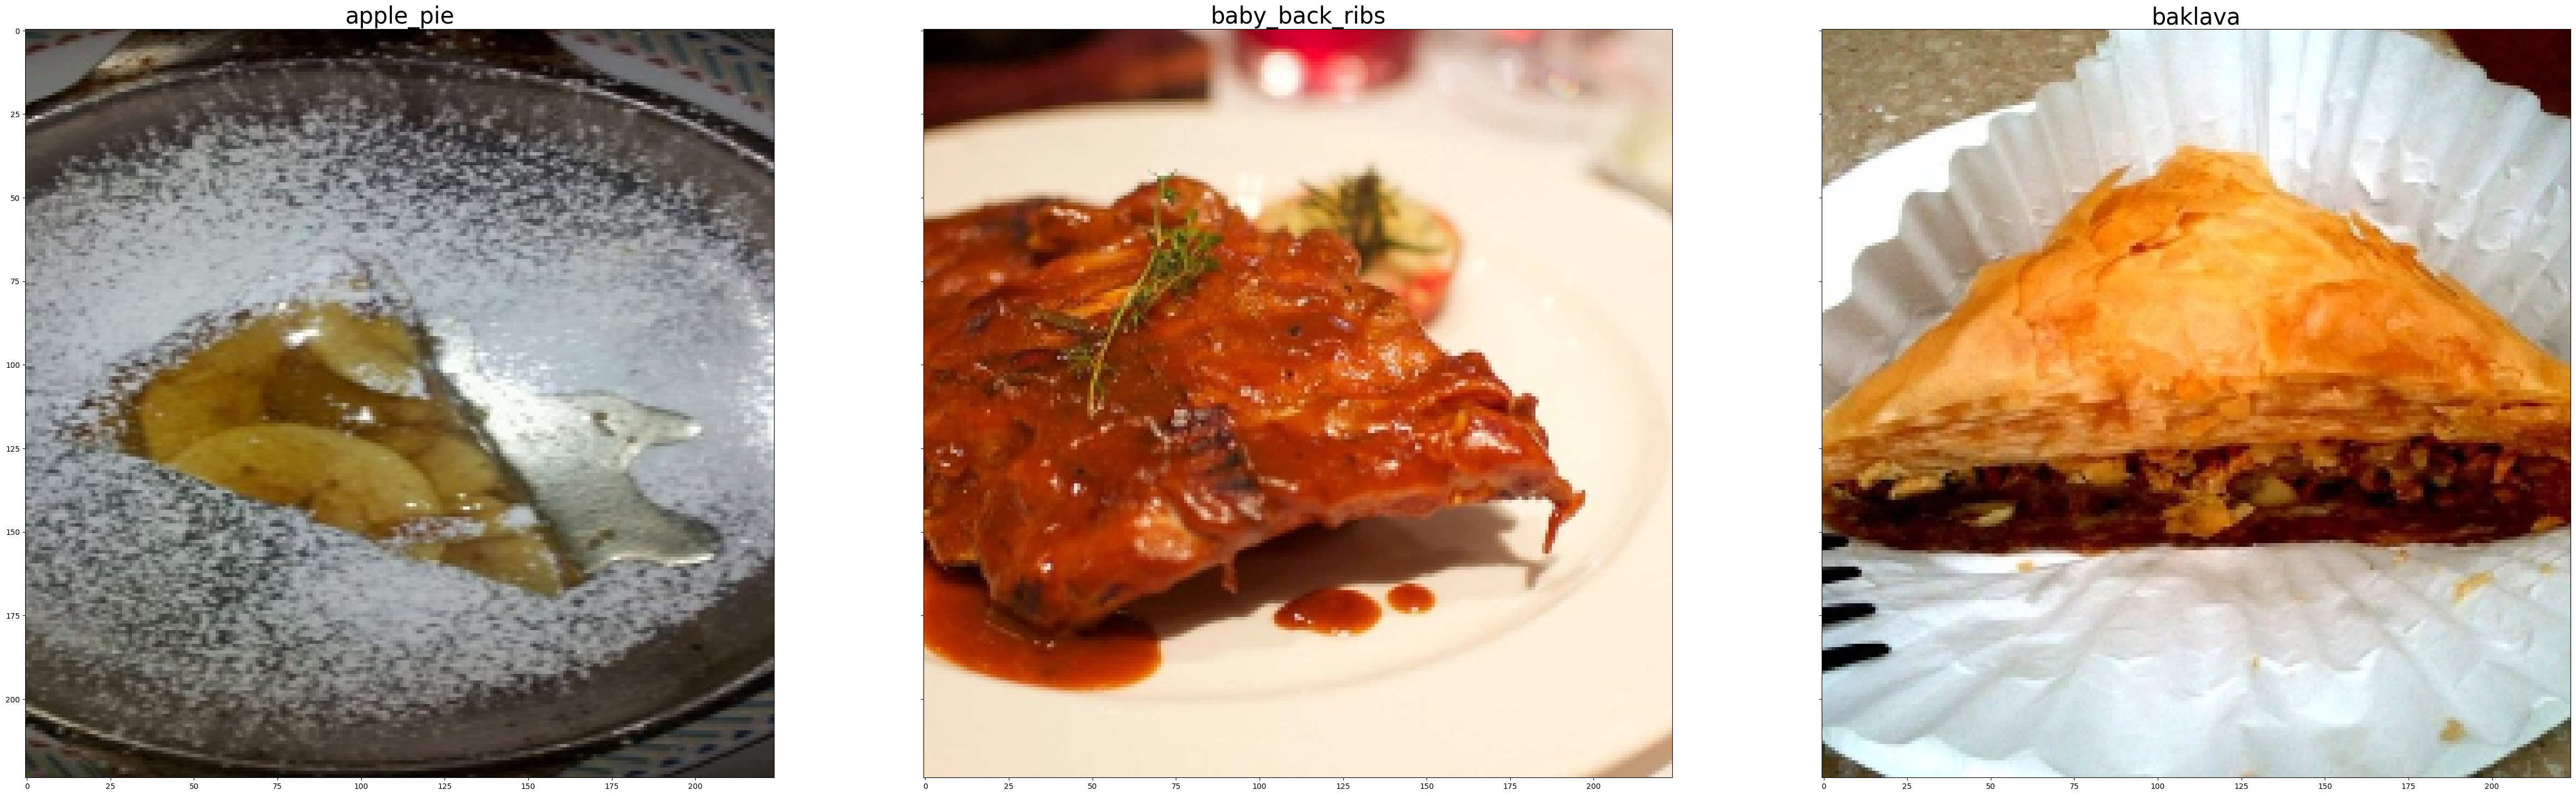

In [ ]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(60, 20))
for axIdx, dataIdx in enumerate([0, 900, 1800]):
    ax[axIdx].imshow(x_train[dataIdx]
    ax[axIdx].set_title(food_numbers[y_train[dataIdx]], fontsize=30)
plt.show()

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255.

In [ ]:
print(f'Train data: ({x_train.shape}, {y_train.shape})')
print(f'Test data: ({x_test.shape}, {y_test.shape})')

Train data: ((9000, 224, 224, 3), (9000,))
Test data: ((1000, 224, 224, 3), (1000,))


# Model Building

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
y_train, y_test = keras.utils.to_categorical(y_train, NUM_CLASS), keras.utils.to_categorical(y_test, NUM_CLASS)

In [ ]:
mobile = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
x = mobile.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(NUM_CLASS, activation='softmax')(x)

In [ ]:
model = keras.Model(mobile.input, output)

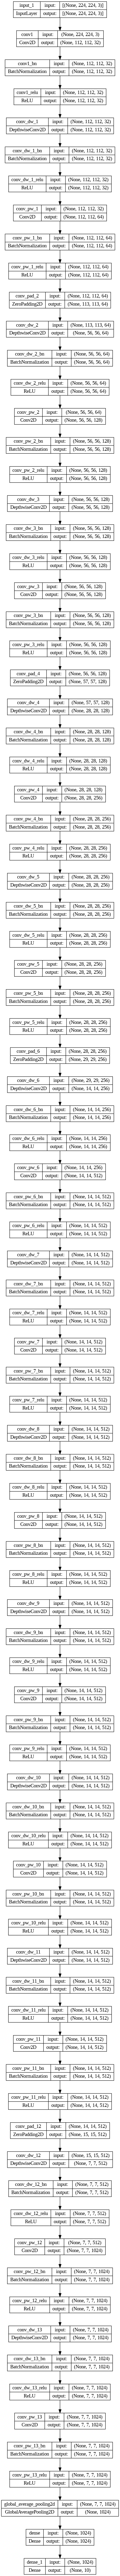

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc', 'loss'])

## Model Training

In [ ]:
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_test, y_test))

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test-Loss: {test_loss}, Test-Acc: {test_acc}')

In [ ]:
with open('README.md', 'a') as file:
    file.write('# Results\n')

    file.write('## Loss\n')
    file.write(f'- Train Loss: {history.history["loss"][-1]:.4f}\n')
    file.write(f'- Test Loss: {test_loss:.4f}\n\n')

    file.write('### Loss Graph\n')
    file.write('![](Loss_Result.png)\n\n')

    file.write('## Accuracy\n')
    file.write(f'- Train Accuracy: {history.history["acc"][-1] * 100:.2f}%\n')
    file.write(f'- Test Accuracy: {test_acc * 100:.2f}%\n')

    file.write('### Accuracy Graph\n')
    file.write('![](Accuracy_Result.png)\n\n')

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legen(['Acc', 'Val Acc'])
plt.title(f'Korean Food Classification {EXPERIMENT_DATA["number"]}(Acc)')

plt.savefig('Accuracy_Result.png')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legen(['Loss', 'Val Loss'])
plt.title(f'Korean Food Classification {EXPERIMENT_DATA["number"]}(Loss)')

plt.savefig('Loss_Result.png')
plt.show()